In [1]:
import os
import numpy as np
from skimage.io import imread
import tensorflow as tf
import random
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Loading dataset

In [2]:
# Parameters
image_folder = 'archive\shipsnet\shipsnet'
image_height, image_width = 128, 128  # Resize dimensions
num_classes = 2

In [3]:
# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Function to load images and extraing HOG features

In [4]:
# Load images and extract HOG features
def load_images_and_hog_features(folder):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.startswith(('1', '0')):
            filepath = os.path.join(folder, filename)
            image = imread(filepath)
            image = resize(image, (image_height, image_width))
            gray_image = rgb2gray(image)
            hog_feature, _ = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
            images.append(hog_feature)
            labels.append(int(filename[0]))  
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_images_and_hog_features(image_folder)
labels = to_categorical(labels, num_classes=num_classes)

In [6]:
correct_hog_feature_size = images.shape[1]

## Defining model

In [7]:

model = Sequential([
    Dense(4096, activation='relu', input_shape=(correct_hog_feature_size,)),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              2363392   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               5

## Spliting dataset

In [9]:
# Split the data into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.optimizers import Adam

# Compile the model with the same hyperparameters
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(images_train, labels_train, epochs=30, validation_split=0.2)

Epoch 1/30
80/80 [==============================] - 3s 21ms/step - loss: 0.5591 - accuracy: 0.7500 - val_loss: 0.5461 - val_accuracy: 0.7203
Epoch 2/30
80/80 [==============================] - 1s 18ms/step - loss: 0.4903 - accuracy: 0.7762 - val_loss: 0.4325 - val_accuracy: 0.7812
Epoch 3/30
80/80 [==============================] - 1s 17ms/step - loss: 0.3681 - accuracy: 0.8512 - val_loss: 0.3753 - val_accuracy: 0.8359
Epoch 4/30
80/80 [==============================] - 1s 16ms/step - loss: 0.3263 - accuracy: 0.8723 - val_loss: 0.3532 - val_accuracy: 0.8422
Epoch 5/30
80/80 [==============================] - 1s 16ms/step - loss: 0.2936 - accuracy: 0.8852 - val_loss: 0.2109 - val_accuracy: 0.9219
Epoch 6/30
80/80 [==============================] - 1s 17ms/step - loss: 0.2558 - accuracy: 0.9023 - val_loss: 0.2390 - val_accuracy: 0.9016
Epoch 7/30
80/80 [==============================] - 1s 16ms/step - loss: 0.2401 - accuracy: 0.9035 - val_loss: 0.3709 - val_accuracy: 0.8547
Epoch 8/30
80

## Testing accuracy on Test set

In [11]:
test_loss, test_acc = model.evaluate(images_test, labels_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

25/25 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9438
Test Accuracy: 94.38%


In [12]:
# Prediction on the test set
predictions = model.predict(images_test)

25/25 [==============================] - 0s 5ms/step


In [13]:
def display_images(images, labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[i])}")
        plt.axis('off')
    plt.show()

In [14]:
# Load original images for display
def load_original_images(folder, indices):
    original_images = []
    filenames = sorted([f for f in os.listdir(folder) if f.startswith(('1', '0'))])
    for idx in indices:
        filepath = os.path.join(folder, filenames[idx])
        image = imread(filepath)
        image = resize(image, (image_height, image_width))
        original_images.append(image)
    return np.array(original_images)

In [15]:
# Get indices of test images
test_indices = np.random.choice(len(images_test), 10, replace=False)
original_test_images = load_original_images(image_folder, test_indices)

## Predictions on test images

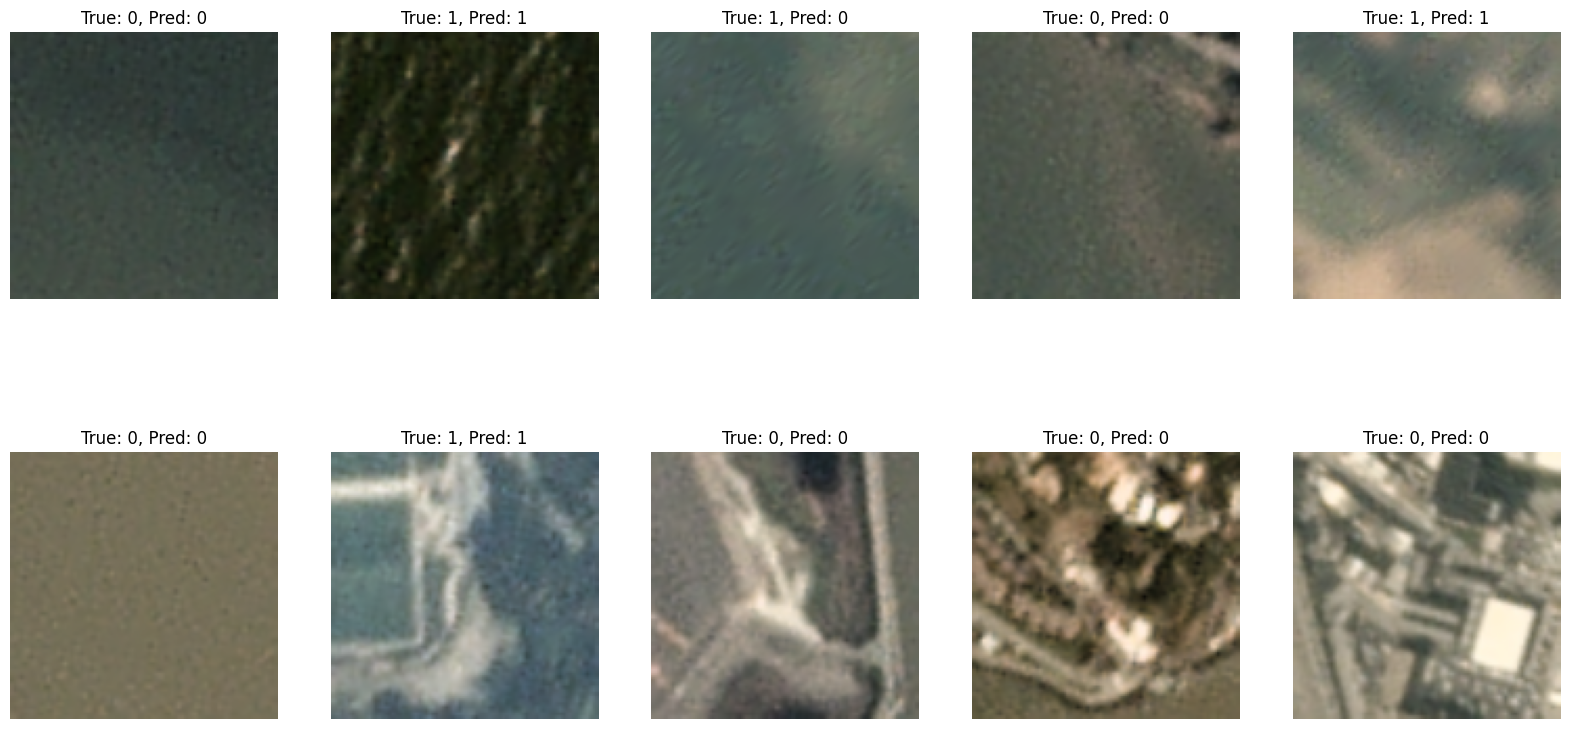

In [16]:
# Display the images
display_images(original_test_images, labels_test[test_indices], predictions[test_indices])

## Plot of accuracy and loss curves

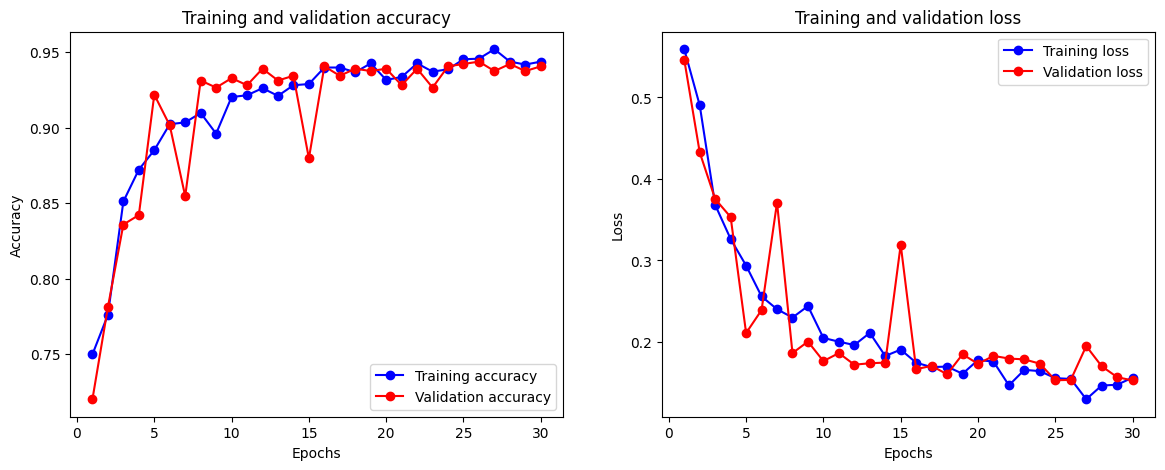

In [17]:
# Plot of accuracy and loss curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot of learning curves
plot_learning_curves(history)

## Classification Report

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Making predictions on the test set
predictions = model.predict(images_test)
predictions = (predictions > 0.5).astype(int)

# Generate classification report
report = classification_report(labels_test, predictions, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

25/25 [==============================] - 0s 4ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96       616
     Class 1       0.86      0.91      0.88       184

   micro avg       0.94      0.94      0.94       800
   macro avg       0.91      0.93      0.92       800
weighted avg       0.95      0.94      0.94       800
 samples avg       0.94      0.94      0.94       800



## Comparison chart of recall, f1 and precision score

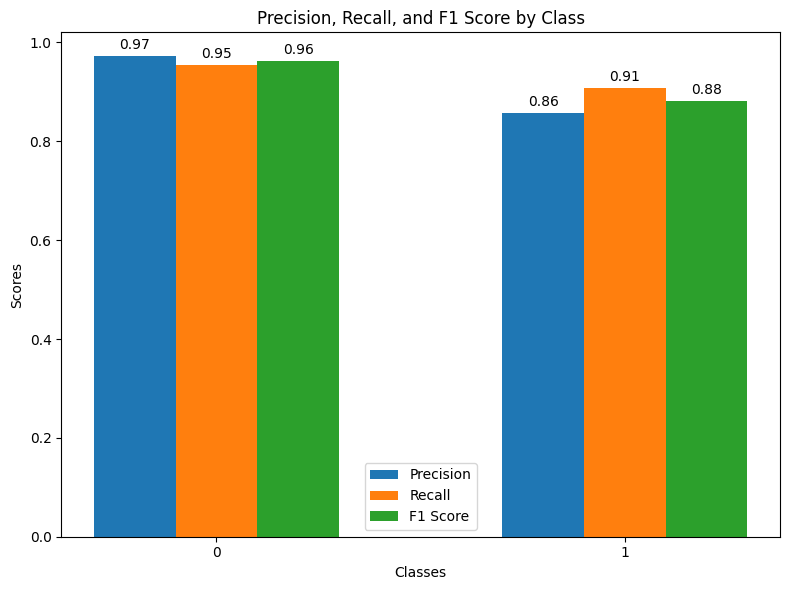

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

labels_test_single = np.argmax(labels_test, axis=1)
predictions_single = np.argmax(predictions, axis=1)


report = classification_report(labels_test_single, predictions_single, output_dict=True)


classes = list(report.keys())[:-3]  
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]


x = np.arange(len(classes))  
width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')


ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

## Confusion matrix

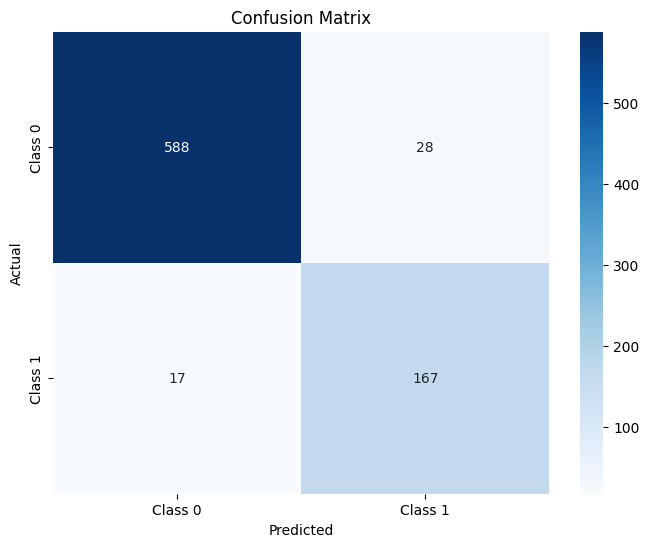

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


labels_test_single = np.argmax(labels_test, axis=1)
predictions_single = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(labels_test_single, predictions_single)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()